In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#code for making artificial dataset
import random
def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,p=0.5):
    seq=''
    for c in seed:
        if random.random() < p: c = random.choice(alphabet_list)
        seq += c
    return seq

def make_artificial_dataset(alphabet='ACGT', motives=None, motif_length=6, 
                            sequence_length=100, n_sequences=1000, n_motives=2, p=0.2,
                           random_state=1):
    random.seed(random_state)
    alphabet_list=[c for c in alphabet]
    
    if motives is None:
        motives=[]
        for i in range(n_motives):
            motives.append(random_string(motif_length,alphabet_list))
    else:
        motif_length = len(motives[0])
        n_motives = len(motives)
    
    sequence_length = sequence_length / len(motives)
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences

    counter=0
    seqs=[]
    binary_seqs=[]
    for i in range(n_seq_per_motif):
        total_seq = ''
        total_binary_seq=''
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,p)
            seq = left_flanking + noisy_motif + right_flanking
            total_seq += seq
            binary_seq = '0' * flanking_length + '1' * motif_length + '0' * flanking_length
            total_binary_seq += binary_seq
        seqs.append(('>ID%d'%counter,total_seq))
        binary_seqs.append(('>ID%d'%counter,total_binary_seq))
        counter += 1
    return motives, seqs, binary_seqs

In [4]:
from eden.motif import SequenceMotif
#help(SequenceMotif)

# Experimental Setup

In [5]:
#setup parameters
alphabet='ACGT'
semi_len=9
motives=['A'*semi_len+'C'*semi_len,
         'C'*semi_len+'A'*semi_len,
         'A'*semi_len+'T'*semi_len,
         'T'*semi_len+'A'*semi_len]
sequence_length=160
n_sequences=200
p=0.2

#make dataset
motives, seqs, binary_seqs = make_artificial_dataset(alphabet=alphabet,
                                        motives=motives,
                                        sequence_length=sequence_length,
                                        n_sequences=n_sequences,
                                        p=p,
                                        random_state=8)

In [6]:
# display first 10 sequences and the corresponding binary sequences
for i in range(10):
    print seqs[i][0]
    print seqs[i][1]
    print binary_seqs[i][1]
    print

>ID0
ATAGAATAGCCAAGAAAAAACCACCTCCCCATAAACCTCACCTATAGGTTGCCCCCCCGCAAATACAAAAAGGATGGAAACGCAAAGCTGGAATAAATAGTTATTCTTTTAAACGGCTATCCAACAGGGACGTTTTTTTTAAAAAAAAACATTGGAAGGG
0000000000011111111111111111100000000000000000000001111111111111111110000000000000000000000111111111111111111000000000000000000000011111111111111111100000000000

>ID1
ACTTCCGTGTGATAAAAAAACCCCCCCCCTGCCCGTCAGCTTCGTTTTAGGCCCCCCCCCAAAAGACAAACTTTAGTGCATAACAGAAGGTATTAAAAAATTTTTTTTTGCTGCGTTTACCATCTGTCAGTTATTTTTTGAAAAAAAAATGACACTCGGA
0000000000011111111111111111100000000000000000000001111111111111111110000000000000000000000111111111111111111000000000000000000000011111111111111111100000000000

>ID2
CTCGAAGTCAAAAAAAAAAACCCCCCCACCCGCGTTGGCTATTAGCTAAAGCCTGCCCCCAAAAAAAAAACTGGGGATCTGAAACGACGCGAAACAAAAATTTTTTTATGCAGGATGTTCGGAGGCCTAAGTTTTTTTTTAAATAAGCATTCTACTGCGC
0000000000011111111111111111100000000000000000000001111111111111111110000000000000000000000111111111111111111000000000000000000000011111111111111111100000000000

>ID3
CCACTGTTCCT

In [7]:
#display
print 'Motives and sample of their perturbed variants:'
alphabet_list=[c for c in alphabet]
for motif in motives: 
    print
    print 'true motif:', motif, ' noisy: ',
    for i in range(4):
        print perturb(motif,alphabet_list,p=p),

Motives and sample of their perturbed variants:

true motif: AAAAAAAAACCCCCCCCC  noisy:  AAAAAAAAACCCACCCCC AAAAAAAACCCCCACCCA AAAAGAAATCCCCCACAC AAATAGACAGACGCCGGC
true motif: CCCCCCCCCAAAAAAAAA  noisy:  CCCCCCCCCTAAAAAAAG CCCCCCCCCACTACAAAG CCCCCCCTCAAAAAAAAG CCCCCCCCCAGAGAAAAA
true motif: AAAAAAAAATTTTTTTTT  noisy:  AAATGAAAATTTTTTTTT ACTAAAAATTTTTATTTT AAATAACAAGGTTCGTAT AAAAAAAAATTTTTTTTT
true motif: TTTTTTTTTAAAAAAAAA  noisy:  TTTTTTTTTAAAGAAAAA TTTTTTTTTAAAAAAATA TTTTTTATGAAACATCAA AGTTTTTTTAAAATAAAA


In [8]:
from sklearn.cluster import KMeans
from eden_wrapper import EdenWrapper
from meme_wrapper import Meme

In [9]:
# choice=1,    # 1 for EDeN, 2 for MEME

alphabet = 'dna'    # Sequence type
nmotifs = 4    # No. of motives to be found
minw = len(motives[0])-2    # Minimum width of motif
maxw = len(motives[0])+2    # Maximum width of motif

# Parameters for logos
output_format='png'
sequence_type = 'rna'
resolution=200
stacks_per_line=40
units='probability'

<h3>For EDeN:</h3>

In [10]:
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=2)

In [24]:
%%time
km = KMeans(n_clusters=nmotifs)
tool = EdenWrapper(alphabet=alphabet, 
                   complexity=5, 
                   nbits=14, 
                   negative_ratio=3,
                   min_subarray_size=minw, 
                   max_subarray_size=maxw,
                   clustering_algorithm=km,
                   
                   wl_output_format=output_format,
                   wl_resolution=resolution,
                   wl_stacks_per_line=stacks_per_line,
                   wl_units=units)
tool.fit(seqs)

Positive data: Instances: 200 ; Features: 16385 with an avg of 3578 features per instance
Negative data: Instances: 600 ; Features: 16385 with an avg of 3707 features per instance
Elapsed time: 37.6 secs
model induction: 200 positive instances 39 s
motives extraction: 195 motives in 9s
motives clustering: 4 clusters in 0s
after filtering: 179 motives 4 clusters in 0s
motif model construction in 0s
updated motif counts in 0s
CPU times: user 28.7 s, sys: 3.58 s, total: 32.3 s
Wall time: 50.3 s


<h3>For MEME:</h3>

In [8]:
%%time
# save input sequences as fasta file for MEME tool
with open('seqs.fa','w') as f_train:
    for seq in seqs:
        f_train.write('>' + seq[0] + ' \n')
        f_train.write(seq[1] + '\n')

tool =  Meme(alphabet='dna',
             minw=minw,
             maxw=maxw,
             nmotifs=nmotifs,
             
             wl_output_format=output_format,
             wl_resolution=resolution,
             wl_stacks_per_line=stacks_per_line,
             wl_units=units)
tool.fit('seqs.fa')

CPU times: user 104 ms, sys: 12 ms, total: 116 ms
Wall time: 52.8 s


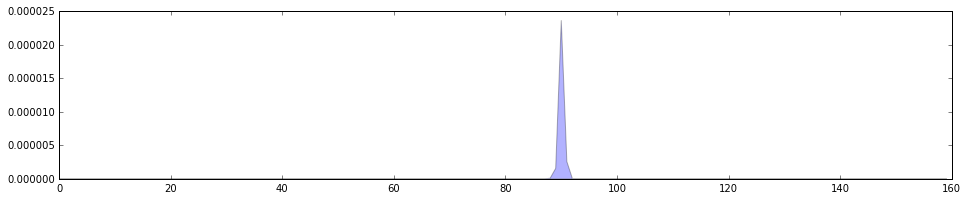

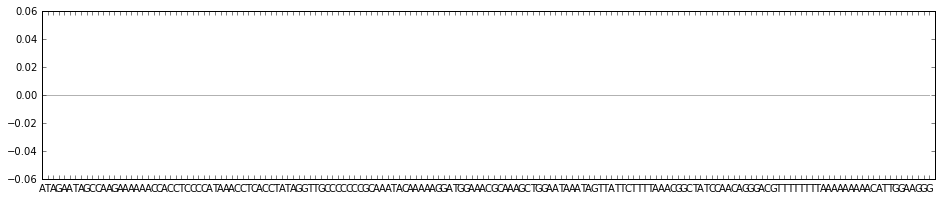

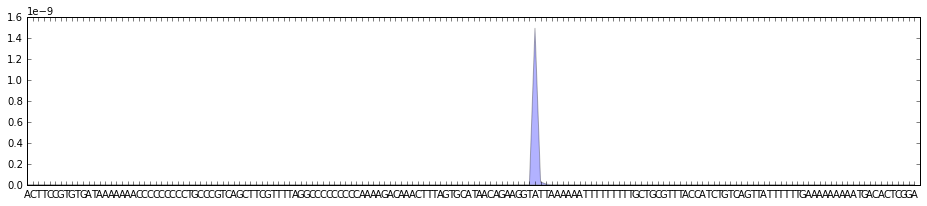

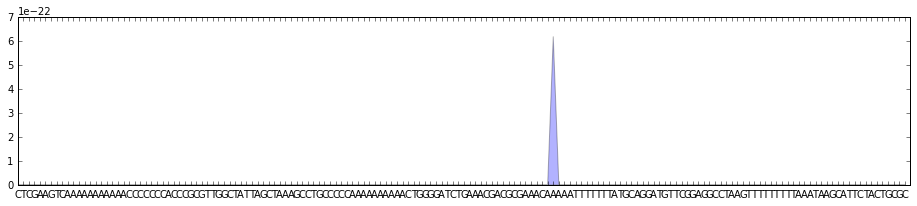

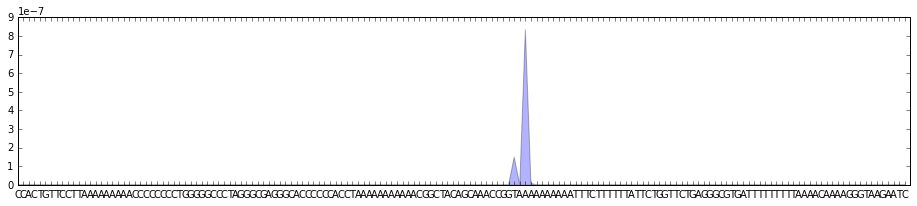

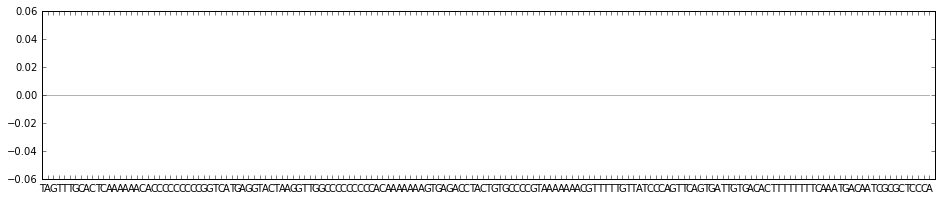

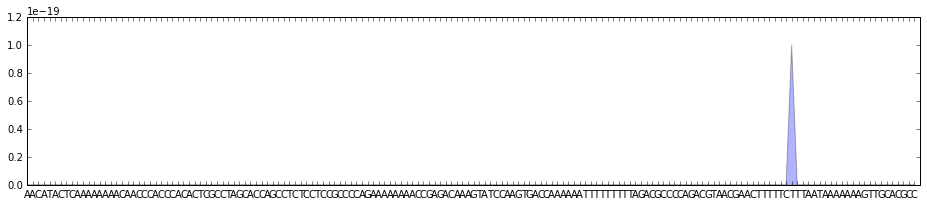

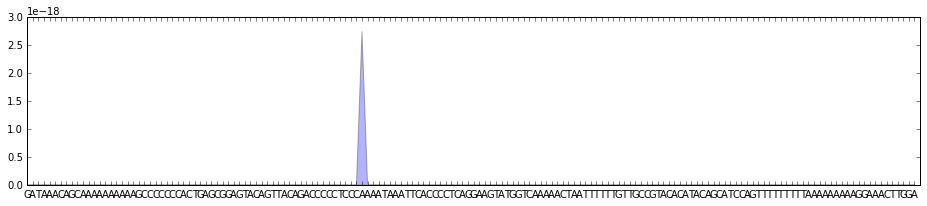

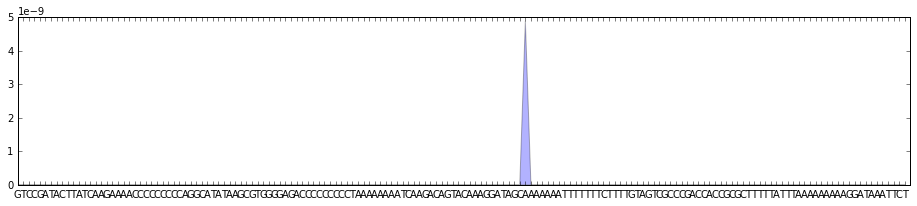

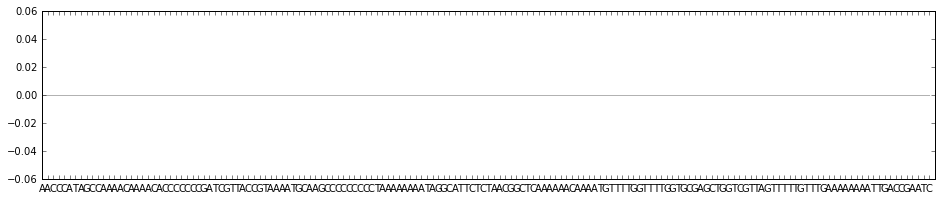

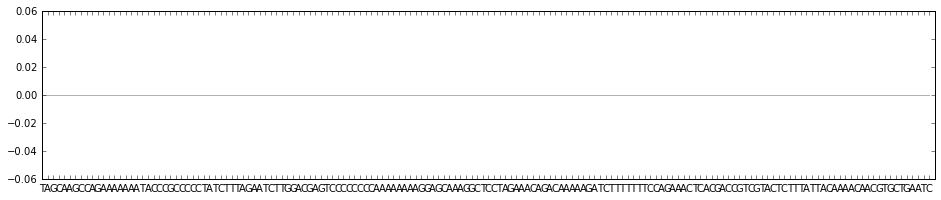

In [25]:
% matplotlib inline
import pylab as plt 
import numpy as np
sig = np.zeros(sequence_length)

for i in range(len(seqs)):
    # Only scoring against single motif
    score = tool.score(motif_num=1, seq=seqs[i][1], zero_padding=True)
    sig += np.array(score)
sig /= float(len(seqs))
sig *= len(motives)
plt.figure(figsize=(16,3))
plt.fill_between(range(len(sig)), 0, sig, alpha=0.3)
plt.show()


print
print

for i in range(len(seqs[:10])):
    score = tool.score(motif_num=1, seq=seqs[i][1], zero_padding=True)
    plt.figure(figsize=(16,3))
    plt.fill_between(range(len(score)), 0, score, alpha=0.3)
    plt.xticks(range(len(score)), seqs[i][1])
    plt.show()

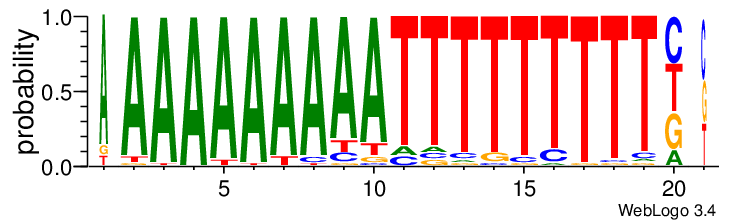

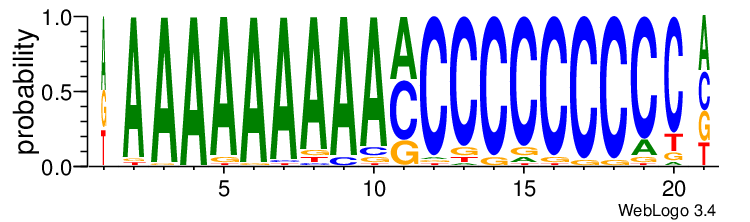

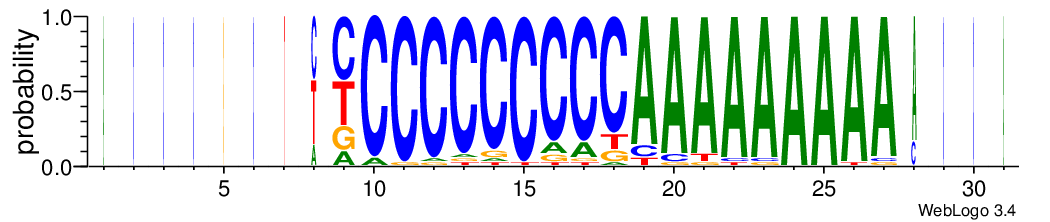

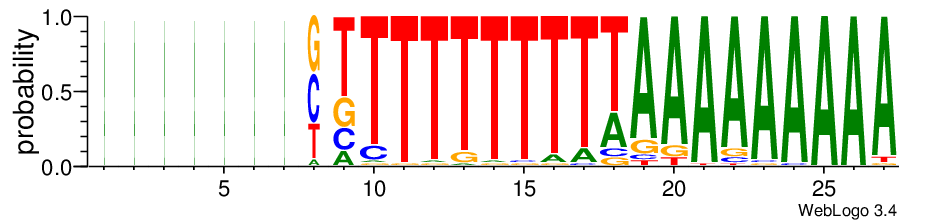

In [26]:
tool.display_logo(do_alignment=True)

find a way to re-evaluate each sequence in a cluster according to the alignment and filter out the bad ones

<h1>Scoring Methods Comparison</h1>

<h4>Scoring with PWM</h4>

In [27]:
%%time
test_seq = seqs[0][1]
score_pwm = tool.score(motif_num=1, seq=test_seq)
print score_pwm

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 12.5 ms


In [ ]:
%%time
test_seq = seqs[0][1][:20]
score_mm = tool.score_mm(motif_num=1, seq=test_seq)
print score_mm

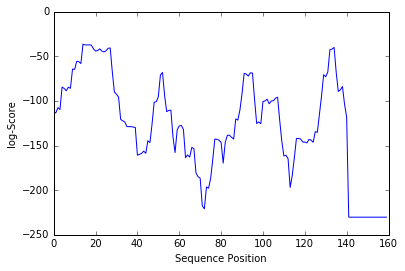

In [80]:
import matplotlib.pyplot as plt
plt.plot(score_mm)
plt.xlabel('Sequence Position')
plt.ylabel('Score')
plt.show()

In [86]:
from sklearn.metrics import roc_auc_score

true_score = [float(int(x)) for x in binary_seqs[0][1]]
roc_score = roc_auc_score(true_score, score_mm)
print "ROC Score: ", roc_score


NameError: name 'score_mm' is not defined